Цель проекта

Провести анализ данных A/B теста нового алгоритма доставки, который оптимизирует последние заказы курьеров так, чтобы они совпадали с их маршрутом домой. Мы сравним среднее время доставки между двумя группами курьеров:
	•	Control (старый алгоритм)
	•	Test (новый алгоритм с опцией “по пути”)

Цель — понять, улучшает ли новый алгоритм среднее время доставки, и принять решение о его дальнейшем внедрении.

План работы
	1.	Загрузка и первичная обработка данных:
	•	Проверка структуры данных (размерность, типы данных, пропуски).
	•	Описание и распределение данных по группам.
	2.	Анализ данных:
	•	Исследование времени доставки по группам.
	•	Визуализация распределений для сравнения.
	3.	Статистическое сравнение средних значений:
	•	Проведение T-теста для проверки гипотезы о различии средних значений между группами.
	•	Интерпретация результатов.
	4.	Выводы и рекомендации.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
%matplotlib inline

In [90]:
df = pd.read_csv("../analytics/experiment_lesson_4.csv")

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


In [92]:
df.sample(5)

,order_id,delivery_time,district,experiment_group
6878,8715,47.0,Purlieus,control
13431,19947,28.0,Central,test
2093,5446,56.0,Purlieus,control
9673,10410,47.0,Purlieus,control
18175,18355,48.0,Purlieus,test


In [93]:
df.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [101]:
# Фильтруем данные по экспериментальным группам:
# 1. Контрольная группа (старый алгоритм) — сохраняем только время доставки
control = df[df['experiment_group'] == 'control']['delivery_time']

# 2. Тестовая группа (новый алгоритм с опцией "по пути") — сохраняем время доставки
test = df[df['experiment_group'] == 'test']['delivery_time']

In [102]:
df

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


Формулировка гипотез

		Верно: Нулевая гипотеза (H0) — разницы между средним временем доставки в тестовой и контрольной группе нет.
		Нулевая гипотеза (H0) предполагает, что новый алгоритм не оказывает статистически значимого влияния на время доставки.
        
		Альтернативная гипотеза (H1) утверждает, что разница существует.

No handles with labels found to put in legend.


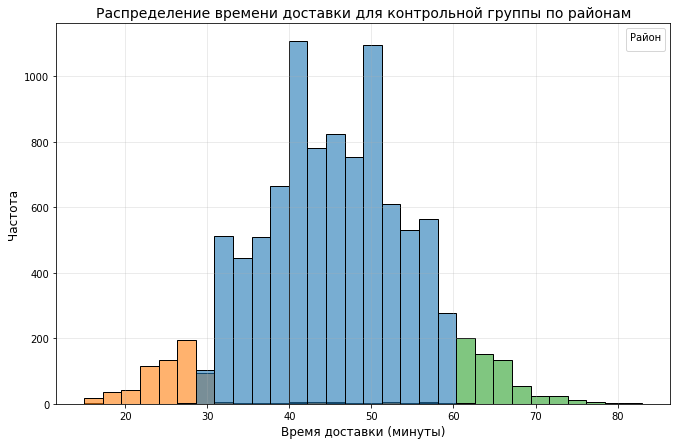

In [95]:
# График распределения времени доставки для контрольной группы по районам
plt.figure(figsize=(11, 7))

sns.histplot(data=df[df['experiment_group'] == 'control'], 
             x='delivery_time', 
             hue='district', 
             bins=30, 
             alpha=0.6)
plt.title('Распределение времени доставки для контрольной группы по районам', fontsize=14)
plt.xlabel('Время доставки (минуты)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.legend(title='Район')
plt.grid(alpha=0.3)
plt.show()

Цель данного этапа — сравнить распределения времени доставки в контрольной группе (старый алгоритм) и тестовой группе (новый алгоритм) для проверки гипотезы о равенстве средних значений.

In [96]:
df['district'].value_counts()

Purlieus    16960
Central      2396
Suburb        840
Name: district, dtype: int64

No handles with labels found to put in legend.


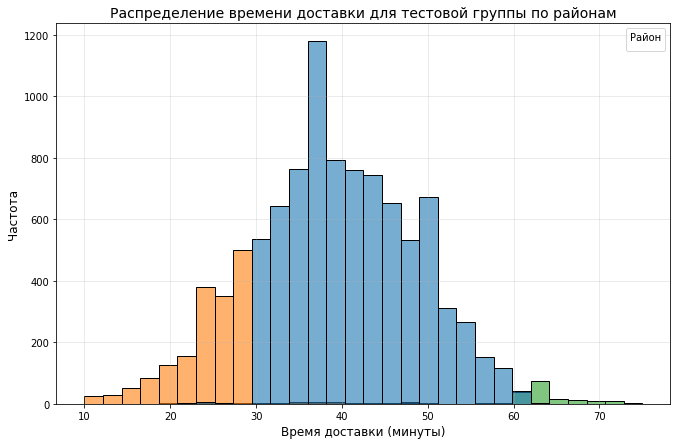

In [97]:
# График распределения времени доставки для тестовой группы по районам
plt.figure(figsize=(11, 7))

sns.histplot(data=df[df['experiment_group'] == 'test'], 
             x='delivery_time', 
             hue='district', 
             bins=30, 
             alpha=0.6)
plt.title('Распределение времени доставки для тестовой группы по районам', fontsize=14)
plt.xlabel('Время доставки (минуты)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.legend(title='Район')
plt.grid(alpha=0.3)
plt.show()


Проверим количество наблюдений в тестовой и контрольной группах и посчитать их разницу.

In [98]:
# Считаем количество наблюдений для тестовой группы
test_shape = df[df['experiment_group'] == 'test'].shape[0]

# Считаем количество наблюдений для контрольной группы
control_shape = df[df['experiment_group'] == 'control'].shape[0]

# Находим разницу в количестве наблюдений между группами
test_shape - control_shape

12

Pазница между тестовой и контрольной группами составляет 12 наблюдений, что можно считать допустимым отклонением
при равномерном распределении на практике.

1.	Проверяем нормальность распределения:

		Используем тест Агостино-Пирсона через scipy.stats.normaltest() для контрольной и тестовой групп.
        
        Нулевая гипотеза теста: данные распределены нормально
        
2.	Считаем стандартное отклонение:

		Оно показывает, насколько сильно время доставки варьируется вокруг среднего значения для каждой группы.

In [99]:
# Импорт библиотек
import scipy as scipy
from scipy.stats import normaltest
import pingouin as pg

# Фильтруем данные по группам
test_group = df.query("experiment_group == 'test'")['delivery_time']
control_group = df.query("experiment_group == 'control'")['delivery_time']

# Проверка нормальности распределения
print("Тест нормальности для тестовой группы:")
print(scipy.stats.normaltest(test_group))
print("\nТест нормальности для контрольной группы:")
print(scipy.stats.normaltest(control_group))

# Проверка через pingouin
print("\nРезультаты через pingouin:")
print(pg.normality(data=df, dv="delivery_time", group="experiment_group", method="normaltest"))

# Стандартное отклонение для обеих групп
print("\nСтандартное отклонение:")
print("Тестовая группа:", round(test_group.std(), 2))
print("Контрольная группа:", round(control_group.std(), 2))

Тест нормальности для тестовой группы:
NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

Тест нормальности для контрольной группы:
NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

Результаты через pingouin:
                W      pval  normal
control  0.253498  0.880955    True
test     7.024157  0.029835   False

Стандартное отклонение:
Тестовая группа: 9.88
Контрольная группа: 9.99


	Нормальность:
		Тестовая группа: p-value = 0.0298 ⟶ распределение не является нормальным (отклоняем H0).
		Контрольная группа: p-value = 0.88 ⟶ распределение нормальное (принимаем H0).


Чтобы посчитать t-статистику для сравнения средних значений между тестовой и контрольной группами, используем t-тест Стьюдента из модуля scipy.stats

In [100]:
from scipy.stats import ttest_ind

# Проведение t-теста
t_stat, p_value = ttest_ind(test_group, control_group, equal_var = False)  # Welch's t-test

# Вывод результатов
print(f"t-статистика: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

t-статистика: -43.04
p-value: 0.0000


Сравнение средних значений с использованием t-теста

Для проверки разницы между средним временем доставки в контрольной и тестовой группах используем t-тест Стьюдента.
	1.	Нулевая гипотеза (H0): Среднее время доставки в тестовой и контрольной группах не различается.
	2.	Альтернативная гипотеза (H1): Среднее время доставки различается между группами.


	t-тест подходит для сравнения средних двух групп, даже если данные слегка отклоняются от нормального распределения, благодаря большому объему выборок.
	Также проверил значение p-value, чтобы понять, статистически значимо ли это различие.

Вывод:
		Статистика t-теста равна -43.
		Значение p-value ≤ 0.05, что позволяет отвергнуть нулевую гипотезу.
		Это говорит о том, что среднее время доставки в тестовой и контрольной группах различается.

Таким образом, новый алгоритм “по пути” оказывает влияние на скорость доставки.

# Графическое представление

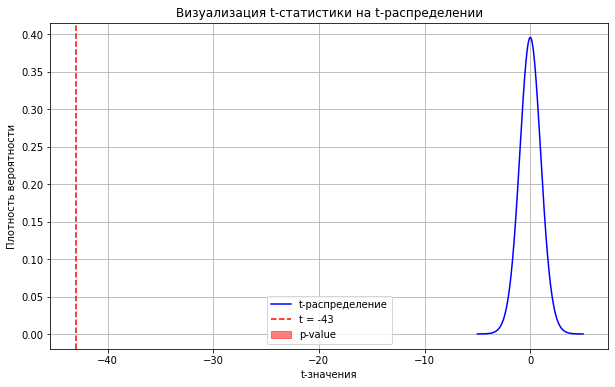

In [80]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# Параметры
df = 30  # Степени свободы
t_value = -43  # t-статистика

# Генерация t-распределения
x = np.linspace(-5, 5, 1000)  # Диапазон значений t-распределения
y = t.pdf(x, df)  # Плотность распределения

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='t-распределение', color='blue')
plt.axvline(t_value, color='red', linestyle='--', label=f't = {t_value}')
plt.fill_between(x, 0, y, where=(x <= t_value), color='red', alpha=0.5, label='p-value')

# Настройки
plt.title('Визуализация t-статистики на t-распределении')
plt.xlabel('t-значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()

На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной ?


In [81]:
# Расчёт процента изменения среднего времени доставки
percent_of_chanch = ((test_group.mean() - control_group.mean()) / control_group.mean()) * 100
percent_of_chanch

-13.354653121660812

In [82]:
control_group.mean()

45.065101070154576

In [83]:
test_group.mean()

39.04681314330958

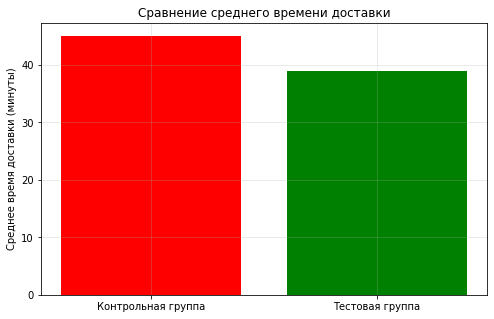

In [84]:
import matplotlib.pyplot as plt

# Средние значения
mean_control = control_group.mean()  # Среднее для контрольной группы
mean_test = test_group.mean()  # Среднее для тестовой группы

# Построение графика
plt.figure(figsize=(8, 5))
plt.bar(['Контрольная группа', 'Тестовая группа'], [mean_control, mean_test], color=['red', 'green'])
plt.title('Сравнение среднего времени доставки')
plt.ylabel('Среднее время доставки (минуты)')
plt.grid(alpha=0.3)
plt.show()

	Результат:
Среднее время доставки уменьшилось на 13.35%.
Это говорит о том, что новая функция позволила курьерам завершать доставку быстрее, что значительно улучшило эффективность.

Вывод:
	1.	В тестовой группе, где использовался новый алгоритм, среднее время доставки сократилось на 13.35% (примерно на 6 минут).
	2.	Разница между группами визуально заметна на графике и подтверждается расчётами.
	3.	Новый алгоритм эффективен и может быть рекомендован к использованию для всех курьеров.

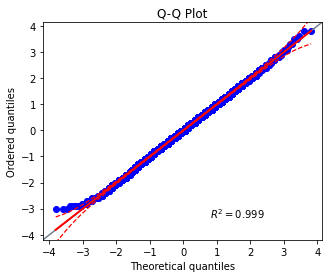

In [104]:
import pingouin as pg

# Фильтрация данных для контрольной группы
control_delivery = df.query("experiment_group == 'control'")['delivery_time']

# Построение QQ-плота
pg.qqplot(control_delivery)

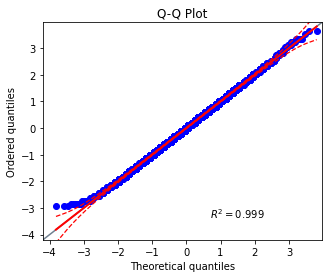

In [105]:
# Фильтрация данных для тестовой группы
control_delivery = df.query("experiment_group == 'test'")['delivery_time']

# Построение QQ-плота
pg.qqplot(control_delivery)